# CNN + LSTM + Dense 
Before adding attention layers, establish the most we can do with Dense layers.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-19 20:55:32.472816
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=2000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-19 20:56:00.214407
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-19 20:56:01.772444
Load sequence...
2022-12-19 20:56:24.959751
Num IDs: 34915
Example IDs: [('ENSG00000187608', 'ENST00000624652.1'), ('ENSG00000162571', 'ENST00000673999.1'), ('ENSG00000186827', 'ENST00000699976.1'), ('ENSG00000160087', 'ENST00000422076.5')]
Count 17845 ones out of 34915 labels.
Example labels: [1, 0, 0, 1]
Num counts: 34915
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-19 20:56:24.999810
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1997, 4)           1028      
                                                                 
 bidirectional (Bidirectiona  (None, 1997, 32)         2688      
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 1990, 64)          16448     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,229


## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-19 20:56:28.763061
2022-12-19 20:56:28.763231
splitting
Fold 1
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27856, 1997) (27856, 1)
Valid sizes (7059, 1997) (7059, 1)
Train set ones/size 14271 / 27856
Valid set ones/size 3574 / 7059
BUILD MODEL
COMPILE
FIT
2022-12-19 20:56:33.203709
Epoch 1/5
871/871 [==============================] - 106s 107ms/step - loss: 0.6343 - accuracy: 0.6423 - val_loss: 0.6225 - val_accuracy: 0.6643
Epoch 2/5
871/871 [==============================] - 92s 105ms/step - loss: 0.6161 - accuracy: 0.6694 - val_loss: 0.6149 - val_accuracy: 0.6728
Epoch 3/5
871/871 [==============================] - 93s 106ms/step - loss: 0.6128 - accuracy: 0.6755 - val_loss: 0.6200 - val_accuracy: 0.6562
Epoch 4/5
871/871 [==============================] - 92s 106ms/step - loss: 0.6100 - accuracy: 0.6744 - val_loss: 0.6146 - val_accuracy: 0.6736
Epoch 5/5
871/871 [==============================] - 92s 106ms/step - loss: 0.6090 - accuracy: 0.6770 - val_loss: 0.

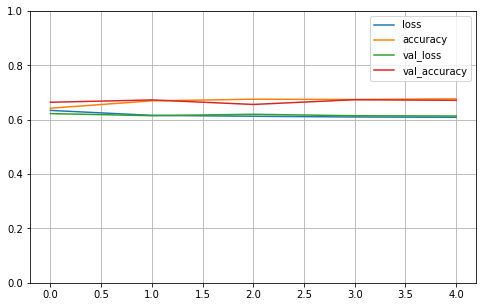

Compute valiation accuracy
2022-12-19 21:04:59.651727
Range of scores: 0.021421202 to 0.9816627
Predicted zeros and ones 3547 3512
Accuracy: 67.13% Precision: 67.85% Recall: 66.68% F1: 67.26%
2022-12-19 21:05:09.972720
Fold 2
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27895, 1997) (27895, 1)
Valid sizes (7020, 1997) (7020, 1)
Train set ones/size 14222 / 27895
Valid set ones/size 3623 / 7020
BUILD MODEL
COMPILE
FIT
2022-12-19 21:05:14.322789
Epoch 1/5
872/872 [==============================] - 98s 109ms/step - loss: 0.6336 - accuracy: 0.6455 - val_loss: 0.6233 - val_accuracy: 0.6583
Epoch 2/5
872/872 [==============================] - 93s 106ms/step - loss: 0.6139 - accuracy: 0.6735 - val_loss: 0.6242 - val_accuracy: 0.6617
Epoch 3/5
872/872 [==============================] - 94s 108ms/step - loss: 0.6108 - accuracy: 0.6728 - val_loss: 0.6249 - val_accuracy: 0.6603
Epoch 4/5
872/872 [==============================] - 94s 107ms/step - loss: 0.6087 - accuracy: 0.6768 - va

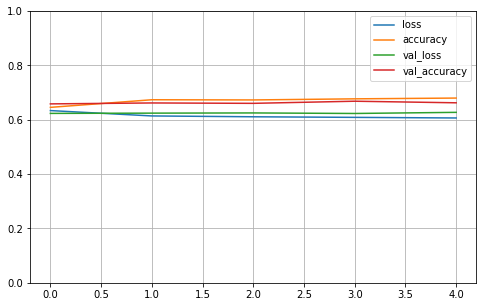

Compute valiation accuracy
2022-12-19 21:13:05.689415
Range of scores: 0.01536017 to 0.9723622
Predicted zeros and ones 4006 3014
Accuracy: 66.23% Precision: 70.77% Recall: 58.87% F1: 64.28%
2022-12-19 21:13:15.928315
Fold 3
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27851, 1997) (27851, 1)
Valid sizes (7064, 1997) (7064, 1)
Train set ones/size 14342 / 27851
Valid set ones/size 3503 / 7064
BUILD MODEL
COMPILE
FIT
2022-12-19 21:13:20.203506
Epoch 1/5
871/871 [==============================] - 97s 108ms/step - loss: 0.6297 - accuracy: 0.6538 - val_loss: 0.6414 - val_accuracy: 0.6318
Epoch 2/5
871/871 [==============================] - 93s 107ms/step - loss: 0.6122 - accuracy: 0.6747 - val_loss: 0.6372 - val_accuracy: 0.6435
Epoch 3/5
871/871 [==============================] - 94s 108ms/step - loss: 0.6086 - accuracy: 0.6791 - val_loss: 0.6433 - val_accuracy: 0.6420
Epoch 4/5
871/871 [==============================] - 93s 106ms/step - loss: 0.6066 - accuracy: 0.6828 - val

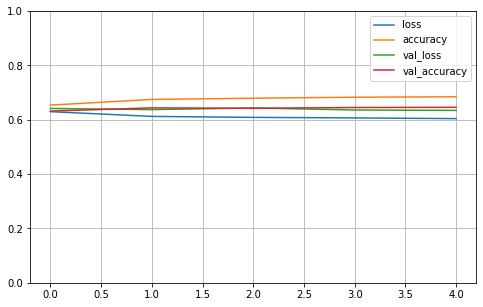

Compute valiation accuracy
2022-12-19 21:21:11.189849
Range of scores: 0.035154402 to 0.98376423
Predicted zeros and ones 3364 3700
Accuracy: 64.57% Precision: 63.51% Recall: 67.09% F1: 65.25%
2022-12-19 21:21:21.512185
Fold 4
Training example
[ 74  39 154 ...   0   0   0]
Train sizes (27866, 1997) (27866, 1)
Valid sizes (7049, 1997) (7049, 1)
Train set ones/size 14293 / 27866
Valid set ones/size 3552 / 7049
BUILD MODEL
COMPILE
FIT
2022-12-19 21:21:25.843220
Epoch 1/5
871/871 [==============================] - 98s 109ms/step - loss: 0.6347 - accuracy: 0.6412 - val_loss: 0.6122 - val_accuracy: 0.6818
Epoch 2/5
871/871 [==============================] - 93s 107ms/step - loss: 0.6205 - accuracy: 0.6632 - val_loss: 0.6105 - val_accuracy: 0.6751
Epoch 3/5
871/871 [==============================] - 94s 108ms/step - loss: 0.6152 - accuracy: 0.6695 - val_loss: 0.6086 - val_accuracy: 0.6829
Epoch 4/5
871/871 [==============================] - 93s 106ms/step - loss: 0.6141 - accuracy: 0.6705 - v

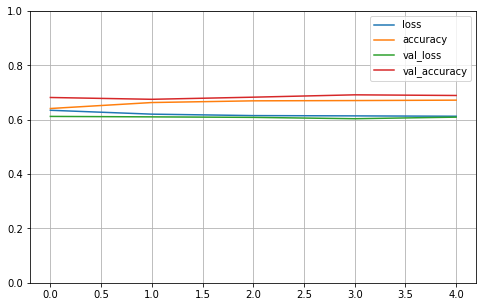

Compute valiation accuracy
2022-12-19 21:29:18.082612
Range of scores: 0.023684634 to 0.9888509
Predicted zeros and ones 2872 4177
Accuracy: 68.92% Precision: 66.29% Recall: 77.96% F1: 71.65%
2022-12-19 21:29:29.023888
Fold 5
Training example
[169 161 129 ...   0   0   0]
Train sizes (28192, 1997) (28192, 1)
Valid sizes (6723, 1997) (6723, 1)
Train set ones/size 14252 / 28192
Valid set ones/size 3593 / 6723
BUILD MODEL
COMPILE
FIT
2022-12-19 21:29:33.310936
Epoch 1/5
881/881 [==============================] - 97s 108ms/step - loss: 0.6356 - accuracy: 0.6399 - val_loss: 0.6102 - val_accuracy: 0.6687
Epoch 2/5
881/881 [==============================] - 94s 107ms/step - loss: 0.6198 - accuracy: 0.6646 - val_loss: 0.6013 - val_accuracy: 0.6945
Epoch 3/5
881/881 [==============================] - 95s 108ms/step - loss: 0.6159 - accuracy: 0.6696 - val_loss: 0.6049 - val_accuracy: 0.6878
Epoch 4/5
881/881 [==============================] - 94s 106ms/step - loss: 0.6131 - accuracy: 0.6672 - va

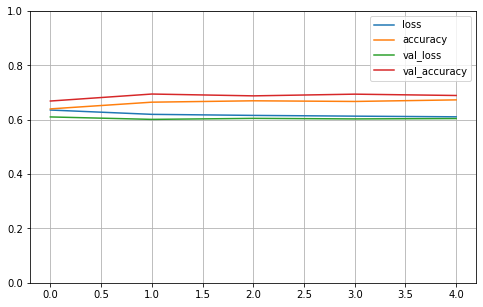

Compute valiation accuracy
2022-12-19 21:37:28.930629
Range of scores: 0.010834355 to 0.98775965
Predicted zeros and ones 2610 4113
Accuracy: 68.91% Precision: 68.27% Recall: 78.15% F1: 72.88%
2022-12-19 21:37:38.878800

Cross validation 5 folds 5 epochs
 accuracy mean 67.15% +/- 1.66
 precision mean 67.34% +/- 2.39
 recall mean 69.75% +/- 7.39
 F1 mean 68.26% +/- 3.43
2022-12-19 21:37:38.882860


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())